# Data Processing Pipeline Test

This notebook validates the credit risk data processing pipeline using sample data
 
## Test Objectives:
1. Verify end-to-end pipeline execution
2. Validate feature engineering logic
3. Check proxy label generation
4. Test outlier treatment and missing value handling

1. Importing necessary libraries and modules

In [33]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root (parent of src) to sys.path
sys.path.insert(0, os.path.abspath('..'))

from src.data_processing import (
    FiveCsFeatureEngineer, 
    RiskLabelGenerator,
    OutlierCapper,
    WoETransformer,
    process_data
)

2. Data loading

In [34]:
df = pd.read_csv('../data/raw/data.csv')

3. Feature Engineering

In [39]:
# Ensure TransactionStartTime is datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

feature_engineer = FiveCsFeatureEngineer()
features = feature_engineer.fit_transform(df)

4. EDA: Feature Overview and Visualization

In [ ]:
# %%
# Analyze Five Cs features
print("Feature Overview:")
print(f"Shape: {features.shape}")
print("\nMissing Values:")
print(features.isna().sum())

# %%
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
sns.histplot(features['payment_consistency'], ax=axes[0,0], kde=True)
axes[0,0].set_title('Payment Consistency')

sns.histplot(features['txn_variability'], ax=axes[0,1], kde=True)
axes[0,1].set_title('Transaction Variability')

sns.histplot(features['avg_spend'], ax=axes[0,2], kde=True)
axes[0,2].set_title('Average Spend')

sns.histplot(features['lifetime_value'], ax=axes[1,0], kde=True)
axes[1,0].set_title('Lifetime Value')

sns.histplot(features['net_cash_flow'], ax=axes[1,1], kde=True)
axes[1,1].set_title('Net Cash Flow')

sns.histplot(features['spend_velocity'], ax=axes[1,2], kde=True)
axes[1,2].set_title('Spend Velocity')

sns.histplot(features['spending_slope'], ax=axes[2,0], kde=True)
axes[2,0].set_title('Spending Slope')

sns.histplot(features['holiday_spending_ratio'], ax=axes[2,1], kde=True)
axes[2,1].set_title('Holiday Spending Ratio')

sns.histplot(features['expected_loss'], ax=axes[2,2], kde=True)
axes[2,2].set_title('Expected Loss')

plt.tight_layout()
plt.show()

Feature Overview:
Shape: (3742, 14)

Missing Values:
CustomerId                  0
payment_consistency         0
fraud_count                 0
txn_variability             0
avg_spend                 110
max_spend                 110
spend_velocity            110
lifetime_value              0
net_cash_flow               0
top_category_share        110
spending_slope              0
holiday_spending_ratio      0
recency                     0
expected_loss               0
dtype: int64


5. Risk Label Generation and Cluster Analysis

2025-06-28 11:18:01,088 - INFO - High-risk customers: 44.29%



Risk Cluster Analysis:
               recency  txn_variability  net_cash_flow  spending_slope  count
is_high_risk                                                                 
0             1.179673        43.998010     414.852795        -0.33264    551
1             1.452055        18.380504     139.589543        -0.05906    438


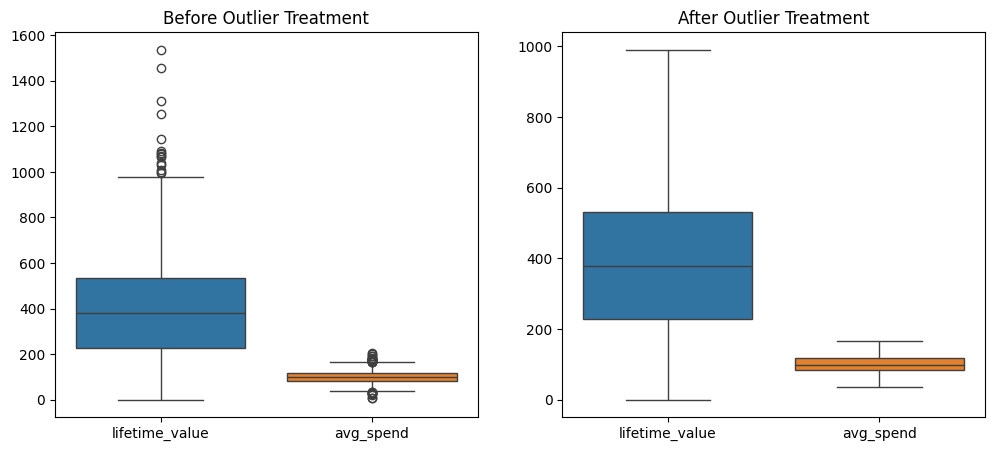

KeyError: 'ProductCategory column is missing in both features and features_labeled.'

In [32]:
# %%
# Test Risk Label Generator
label_generator = RiskLabelGenerator()
features_labeled = label_generator.fit_transform(features)

# Check which columns are available for aggregation
agg_cols = [col for col in ['recency', 'txn_variability', 'net_cash_flow', 'spending_slope'] if col in features_labeled.columns]

# Aggregate means for numeric features by risk label
if agg_cols:
    cluster_means = features_labeled.groupby('is_high_risk')[agg_cols].mean()
else:
    cluster_means = pd.DataFrame()

# Count customers per risk cluster (if CustomerId exists)
if 'CustomerId' in features_labeled.columns:
    cluster_counts = features_labeled.groupby('is_high_risk')['CustomerId'].count().rename('count')
    cluster_analysis = cluster_means.join(cluster_counts)
else:
    cluster_analysis = cluster_means

print("\nRisk Cluster Analysis:")
print(cluster_analysis)

# %%
# Test Outlier Capper
capper = OutlierCapper(factor=1.5)
features_capped = capper.fit_transform(features_labeled)

# Restore ProductCategory for WoE encoding
if 'ProductCategory' in features_labeled.columns:
    features_capped['ProductCategory'] = features_labeled['ProductCategory']

# Compare before/after outlier treatment
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=features_labeled[['lifetime_value', 'avg_spend']], ax=axes[0])
axes[0].set_title('Before Outlier Treatment')

sns.boxplot(data=features_capped[['lifetime_value', 'avg_spend']], ax=axes[1])
axes[1].set_title('After Outlier Treatment')
plt.show()

# %%
# Test WoE Encoder

# --- Restore ProductCategory for WoE encoding safely ---
if 'ProductCategory' in features.columns:
    features_labeled['ProductCategory'] = features['ProductCategory']
    features_capped['ProductCategory'] = features['ProductCategory']
elif 'ProductCategory' in features_labeled.columns:
    features_capped['ProductCategory'] = features_labeled['ProductCategory']
else:
    raise KeyError("ProductCategory column is missing in both features and features_labeled.")


woe_encoder = WoETransformer()
features_encoded = woe_encoder.fit_transform(
    features_capped[['ProductCategory', 'is_high_risk']].copy(),
    features_capped['is_high_risk']
)

print("\nWoE Encoded Values:")
print(features_encoded['ProductCategory'].value_counts())
print(features_encoded['ProductCategory'].value_counts())

2025-06-28 10:54:58,698 - INFO - Loading data from ../data/raw/sample_transactions.csv


2025-06-28 10:54:58,732 - INFO - Engineering features with Five Cs framework
2025-06-28 10:55:01,859 - INFO - Creating proxy risk labels
2025-06-28 10:55:01,880 - INFO - High-risk customers: 44.29%
2025-06-28 10:55:01,880 - INFO - Handling missing values
2025-06-28 10:55:02,361 - INFO - Processed data saved to ../data/processed/sample_features.csv
2025-06-28 10:55:02,361 - INFO - Final shape: (989, 15)



Processed Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerId              989 non-null    object 
 1   payment_consistency     989 non-null    float64
 2   fraud_count             989 non-null    float64
 3   txn_variability         989 non-null    float64
 4   avg_spend               989 non-null    float64
 5   max_spend               989 non-null    float64
 6   spend_velocity          989 non-null    float64
 7   lifetime_value          989 non-null    float64
 8   net_cash_flow           989 non-null    float64
 9   top_category_share      989 non-null    float64
 10  spending_slope          989 non-null    float64
 11  holiday_spending_ratio  989 non-null    float64
 12  recency                 989 non-null    float64
 13  expected_loss           989 non-null    float64
 14  is_high_risk     

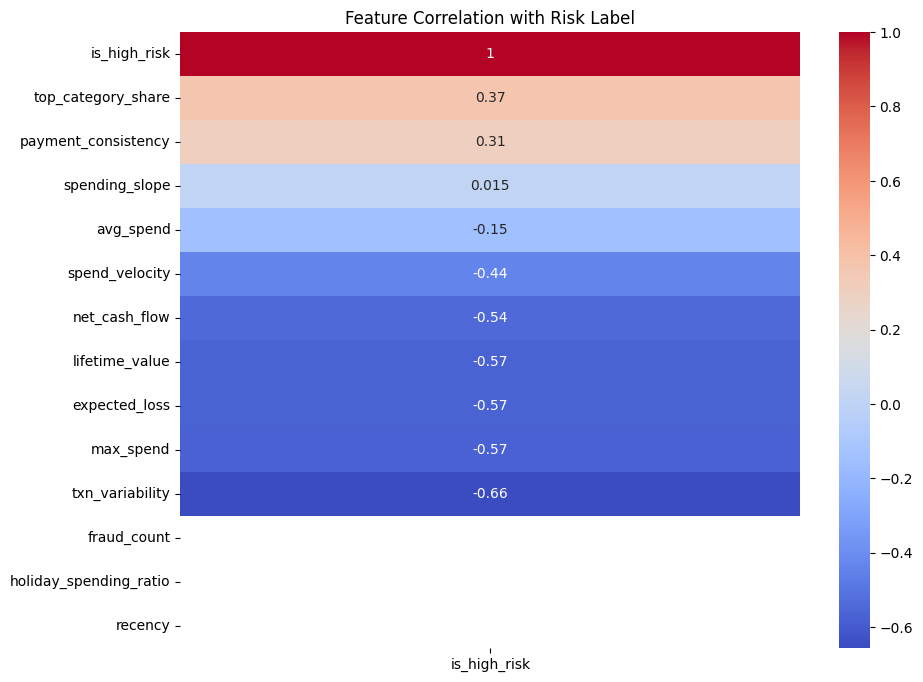

In [ ]:
# %%
# Full pipeline test
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Save sample data
df.to_csv('../data/raw/sample_transactions.csv', index=False)

# Run full pipeline
processed_data = process_data(
    input_csv='../data/raw/sample_transactions.csv',
    output_csv='../data/processed/sample_features.csv'
)

# %%
# Final validation
print("\nProcessed Data Summary:")
print(processed_data.info())
print("\nHigh-Risk Distribution:")
print(processed_data['is_high_risk'].value_counts(normalize=True))

# Correlation with risk
numeric_cols = processed_data.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix[['is_high_risk']].sort_values('is_high_risk', ascending=False), 
    annot=True, cmap='coolwarm'
)
plt.title('Feature Correlation with Risk Label')
plt.show()